In [ ]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
import models.base_networks as bn 
import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

playground_path = os.path.join(result_dir, '20220913_playground_model')
baseline_path = os.path.join(result_dir, '20220615_default_run_mnist')


print(os.path.exists(playground_path))

nb.filter_list('202209', os.listdir(result_dir))

In [2]:
#projname =  'latentPred'
projname =  'latentPredict_rerun'

setting_name = '09292026'
nb.filter_list(projname, os.listdir(result_dir))

['20220926_latentPredict_rerun_0']

In [3]:

targdir = f'''20220926_{projname}_0'''
jobpath = f'''../jobs/{setting_name}_{projname}'''
print(jobpath)
print(os.path.exists(jobpath))
#jobpath = os.path.join('../jobs/','_'.join(targdir.split('_')[:-1]))


targpath = os.path.join(result_dir, targdir)
targlist = os.listdir(targpath)

targlist = nb.model_exists(targlist,  targpath)
print(targlist)

../jobs/09292026_latentPredict_rerun
False
['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']


['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']
['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']


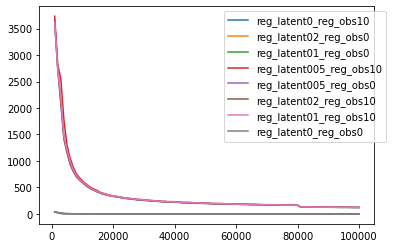

In [4]:
print(os.listdir(targpath))

resultlist = os.listdir(targpath)
print(resultlist)


for result in resultlist:
    studypath = os.path.join(targpath, result)
    history = nb.read_history(studypath)
    if len(history) > 0:
        plt.plot(history['iteration'], history['train/loss'], label = result)
        #print(history['train/loss'][-1])
plt.legend(bbox_to_anchor=(1.05, 1))
#plt.savefig(os.path.join(jobpath, f"""{targdir}_learning.png"""))

In [26]:
reload(ev)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 17
n_cond = 2
device =0
predictive = False
reconstructive = False
repeats=3


#targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 
targdir_pathlist = []
targdir_pathlist.append(playground_path)






In [98]:
reload(ev)
reload(bn)
allresults, targ, xnext = ev.prediction_evalutation(targdir_pathlist, 
                                                                        device =0,
                                                                        n_cond=2,
                                                                        tp=tp,
                                                                        repeats=3,
                           predictive= False , reconstructive = False)

results = allresults['results']

{'args': {'T': 19, 'backgrnd': False, 'max_T': 20, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'train': False}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:03<00:00,  8.01it/s]


tensor([ 4.9265, 10.9692, 18.9168, 25.3447, 30.0879, 34.5331, 39.3800, 43.9570,
        48.4461, 52.0368, 55.5617, 58.6868, 62.0923, 64.7440, 67.7736, 70.4793,
        72.7553])


Text(0.5, 1.0, 'Prediction Error')

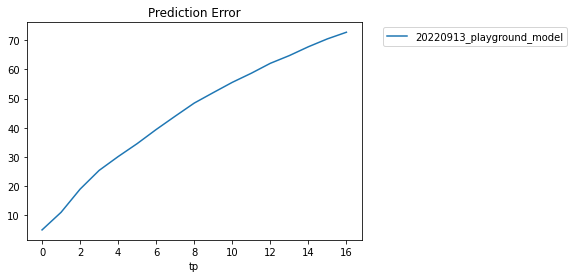

In [99]:
reload(nb)
showresults = []
#showresults = nb.filter_queries([''] , list(results.keys()))

#showresults.append(baseline_path)
showresults.append(playground_path)


for mode in showresults:
    plt.plot(results[mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Prediction Error")

#plt.savefig(os.path.join(jobpath, targdir+'l2loss.png'))

Text(0.5, 0.98, 'difference')

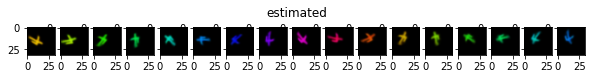

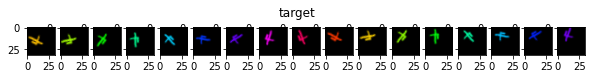

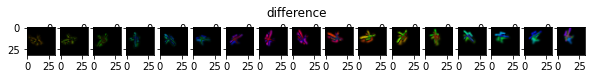

In [82]:
idx = 8
figsize = (10,1)
plt.figure(figsize = figsize)
for k in range(tp):
    xn = torch.permute(xnext[idx][k], (1,2,0))
    plt.subplot(1, tp, k+1)
    plt.imshow(xn)
plt.suptitle("estimated")    


    
plt.figure(figsize = figsize)
for k in range(tp):
    tn = torch.permute(targ[idx][k], (1,2,0))
    plt.subplot(1, tp, k+1)
    plt.imshow(tn)
plt.suptitle("target")    
    
plt.figure(figsize = figsize)
for k in range(tp):
    dn = torch.permute(torch.abs(targ[idx][k] - xnext[idx][k]) , (1,2,0))
    plt.subplot(1, tp, k+1)
    plt.imshow(dn)
plt.suptitle("difference")

In [83]:
deltas = torch.sum((xnext[idx] - targ[idx])**2, axis = [-1, -2, -3])
deltas

tensor([ 4.3046,  5.1149,  5.1171,  7.0770, 10.3843, 12.3656, 15.5329, 29.3800,
        32.4929, 28.3614, 40.2791, 32.4556, 22.4900, 31.7483, 41.9603, 40.2853,
        38.2319])

In [78]:
delta_all = torch.sum((xnext - targ)**2, axis = [-1, -2, -3])
delta_all[idx] - deltas

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
torch.mean(delta_all, axis=0)

tensor([ 4.4612, 12.8527, 23.6181, 37.6716, 46.2281, 59.6309, 68.3966, 69.1845,
        74.5692, 79.2026, 74.8008, 76.3640, 67.7846, 67.5428, 61.1966, 60.2027,
        52.2405])

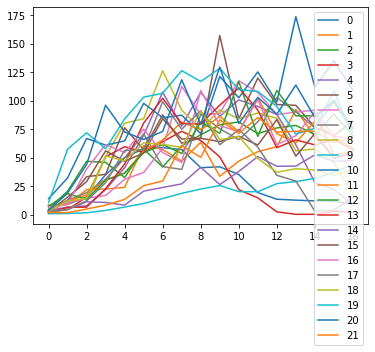

In [80]:
for k in range(len(delta_all)):
    plt.plot(delta_all[k],label=str(k))
plt.legend()

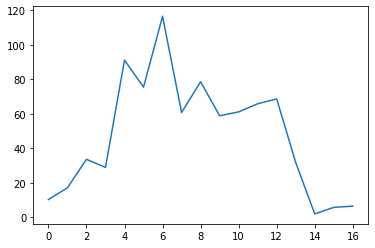

In [73]:
plt.plot(delta_all[5])

In [60]:
delta_all[5]

tensor([ 10.2274,  17.0131,  33.5405,  28.8709,  91.0973,  75.4145, 116.5602,
         60.6768,  78.5688,  58.8103,  61.0789,  65.7728,  68.5851,  31.6887,
          1.8714,   5.6624,   6.3868])